In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import tree 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [59]:
df = pd.read_csv("classification2.csv",index_col=[0])
df.head()

,EXCEPTION_GROUP,WEEKDAY,SITE,MONTH,PROGRAM,SUB_PROGRAM,JOB_FAMILY,EXCEPTION_HOURS,SHIFT_DATE,NOTICE,AWARE,EARNING_CATEGORY
1,12,1,5,4,19,5,7,6.00,2018-04-16,1101563,0.0,Straight Time
2,5,1,4,4,3,16,7,11.25,2017-04-14,9841545,4253367.0,Straight Time
3,3,0,4,4,3,22,7,11.25,2016-04-24,207821,25.0,Overtime and Beyond
4,9,1,3,6,19,40,7,1.50,2017-06-15,92594,4597.0,Overtime and Beyond
5,2,1,4,12,4,27,7,1.50,2016-12-07,804404,8.0,Straight Time


##### Feature Logs:
- Adding "EXCEPTION_GROUP" improved the accruacy around 3%

- "JOB_FAMILY" accutually decreased the accruacy around 0.2%, hence removed.

- "SUB_PROGRAM" and "PROGRAM" works better together

- Using 4 labels, result as below. Since we'd like conservative result, test using 2 labels which is assuming all the exceptions will need relief

|<center>Result</center>|
|-----------------------------------------|
|Random Forest Training Score: 0.873|
|Random Forest Test Score: 0.827|
|Overall Test accuracy for Straight Time : 0.96|
|Straight Time predict as Overtime : 0.027|
|Straight Time predict as Relief Not Found : 0.01|
|Straight Time predict as Others : 0.003|
|Overall Test accuracy for Overtime : 0.352|
|Overtime predict as Straight Time : 0.576|
|Overtime predict as Relief Not Found : 0.067|
|Overtime predict as Others : 0.004|
|Overall Test accuracy for Relief Not Found : 0.407|
|Relief Not Found predict as Straight Time : 0.375|
|Relief Not Found predict as Overtime : 0.216|
|Relief Not Found predict as Others : 0.002|
|Overall Test accuracy for Others : 0.647|
|Others predict as Straight Time : 0.275|
|Others predict as Overtime : 0.071|
|Others predict as Relief Not Found : 0.006|

- Using 2 labels, result as below. 

|<center>Result</center>|
|-----------------------------------------|
|Random Forest Training Score: 0.902|
|Random Forest Test Score: 0.862|
|Overall Test accuracy for Straight Time : 0.935|
|Straight Time predict as Overtime and Beyond : 0.065|
|Overall Test accuracy for Overtime and Beyond : 0.638|
|Overtime and Beyond predict as Straight Time : 0.362|



- Follow Sam's suggestion, using MIN_CALL_DATE_TIME - EXCEPTION_CREATION_DATE as AWARE, means the HR notice that there is an exception and start to find relief. with 2 questions:
    1. Missing data, assign 0 to missing data, in final model could add ifelse, using current time stamp - creation time
    2. How to handle data less than 60 secs, using secs for now

- Oversampling method is not working well
    
### Feature tried but didn't work
- Which week the expection creates
- Which week the expection happens
- How many exception created that week
- How many exception of each label created that week
- Job Family, used to work, after program and reason, not work.

In [63]:
# split data to train and validation
train = df[(df["SHIFT_DATE"]>"2012-12-31") & (df["SHIFT_DATE"]<"2017-01-01")]
val = df[(df["SHIFT_DATE"]>"2016-12-31") & (df["SHIFT_DATE"]<"2018-01-01")]

# Prepare data for model fitting
feature_cols = ["EXCEPTION_HOURS","NOTICE","PROGRAM","SUB_PROGRAM","EXCEPTION_GROUP","AWARE"]
X = train.loc[:, feature_cols]
y = train.EARNING_CATEGORY
X_val = val.loc[:, feature_cols]
y_val = val.EARNING_CATEGORY

# build random forest model and test
RF = RandomForestClassifier(n_estimators=270, 
                            max_depth=15,
                            min_samples_split=6,
                            min_samples_leaf = 7)
RF.fit(X,y)
print("Random Forest Training Score:", round(RF.score(X,y),3))
print("Random Forest Test Score:", round(RF.score(X_val,y_val),3))
pd.DataFrame([list(RF.feature_importances_)],columns = feature_cols)

Random Forest Training Score: 0.915
Random Forest Test Score: 0.868


,EXCEPTION_HOURS,NOTICE,PROGRAM,SUB_PROGRAM,EXCEPTION_GROUP,AWARE
0,0.231108,0.38048,0.040225,0.064464,0.150234,0.13349


In [64]:
# create result dataframe
predictions_RF = RF.predict(X_val)
pred_dict = X_val.copy()
pred_dict['EARNING_CATEGORY'] = y_val
pred_dict['RANDOM_FOREST'] = predictions_RF
result = pd.DataFrame(pred_dict)

# display test accuracy for all EARNING_CATEGORY
for i in df["EARNING_CATEGORY"].unique().tolist():
    print("Overall Test accuracy for",i,":",
          round(result[result["EARNING_CATEGORY"]==i][result["RANDOM_FOREST"]==i].shape[0]/
                result[result["EARNING_CATEGORY"]==i].shape[0],3))
    for j in df["EARNING_CATEGORY"].unique().tolist():
        print(i,"predict as",j,":",
              round(result[result["EARNING_CATEGORY"]==i][result["RANDOM_FOREST"]==j].shape[0]/
                result[result["EARNING_CATEGORY"]==i].shape[0],3)
             )
        
result.head(30)

Overall Test accuracy for Straight Time : 0.936
Straight Time predict as Straight Time : 0.936
Straight Time predict as Overtime and Beyond : 0.064
Overall Test accuracy for Overtime and Beyond : 0.663
Overtime and Beyond predict as Straight Time : 0.337
Overtime and Beyond predict as Overtime and Beyond : 0.663


/Users/davyguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/davyguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,EXCEPTION_HOURS,NOTICE,PROGRAM,SUB_PROGRAM,EXCEPTION_GROUP,AWARE,EARNING_CATEGORY,RANDOM_FOREST
2,11.25,9841545,3,16,5,4253367.0,Straight Time,Straight Time
4,1.50,92594,19,40,9,4597.0,Overtime and Beyond,Overtime and Beyond
10,9.00,2672018,4,27,5,7.0,Straight Time,Straight Time
13,7.50,412719,1,45,6,338187.0,Overtime and Beyond,Straight Time
15,7.50,28855363,8,29,11,23139624.0,Straight Time,Straight Time
27,7.50,3719801,19,40,10,1190123.0,Straight Time,Straight Time
28,4.00,6829,8,29,13,170.0,Straight Time,Overtime and Beyond
29,7.50,39197,8,34,13,0.0,Overtime and Beyond,Overtime and Beyond
32,1.50,64123,18,30,5,206.0,Overtime and Beyond,Overtime and Beyond
39,7.50,4550110,4,27,11,2675176.0,Straight Time,Straight Time


In [62]:
neigh = KNeighborsClassifier(n_neighbors=95)
neigh.fit(X, y)
print("Training Accuracy:",neigh.score(X, y))
print("Test Accuracy:",neigh.score(X_val, y_val))

Training Accuracy: 0.8375270748224715
Test Accuracy: 0.7964564154763369


In [398]:
# Find best numbers of neighbours
neighbours = list(range(5,100,2))
knn_training = []
knn_test = []

for i in range(5,100,2):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X, y)
    knn_training.append(neigh.score(X, y))
    knn_test.append(neigh.score(X_val, y_val))

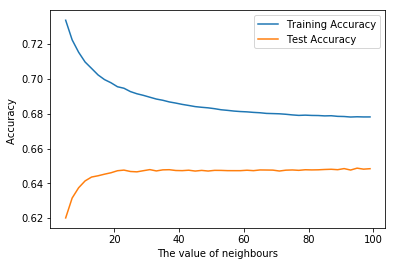

Maximum Traing Accuracy: 0.7337104927004668
Maximum Test Accuracy: 0.6487046956086784
Best neighbours: 95


In [399]:
# plot for kNN accuracy
plt.plot(neighbours, knn_training,label="Training Accuracy")
plt.plot(neighbours, knn_test,label="Test Accuracy")
plt.ylabel("Accuracy ")
plt.xlabel("The value of neighbours")
plt.legend()
plt.show()

print("Maximum Traing Accuracy:",np.max(knn_training))
print("Maximum Test Accuracy:",np.max(knn_test))
print("Best neighbours:",neighbours[np.argmax(knn_test)])

In [266]:
# cross validation for max_depth
md_k = list(range(5,20,1))
md_accuracy = []
    
for i in range(5, 20, 1):
    RF = RandomForestClassifier(n_estimators=10,max_depth=i)
    md_accuracy.append(np.mean(cross_val_score(RF, X, y, cv=10)))

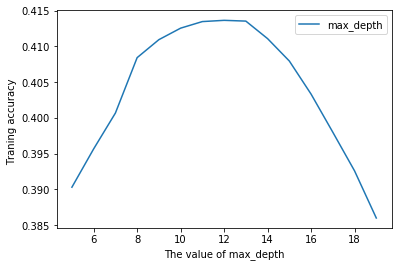

Maximum Accuracy: 0.41364897003454637
Best max_depth: 12


In [267]:
# plot for max_depth
plt.plot(md_k, md_accuracy,label="max_depth")
plt.ylabel("Traning accuracy ")
plt.xlabel("The value of max_depth")
plt.legend()
plt.show()

print("Maximum Accuracy:",np.max(md_accuracy))
print("Best max_depth:",md_k[np.argmax(md_accuracy)])

In [268]:
# cross validation for n_estimators, based on previous best max_depth
ne_k = list(range(50,200,10))
ne_accuracy = []
    
for i in range(50, 200, 10):
    RF = RandomForestClassifier(n_estimators=i,max_depth=12,)
    ne_accuracy.append(np.mean(cross_val_score(RF, X, y, cv=10)))

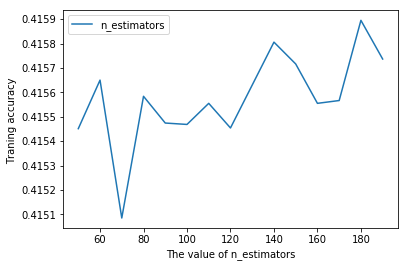

Maximum Accuracy: 0.41589523005821655
Best n_estimators: 180


In [270]:
# plot for n_estimators
plt.plot(ne_k, ne_accuracy,label="n_estimators")
plt.ylabel("Traning accuracy ")
plt.xlabel("The value of n_estimators")
plt.legend()
plt.show()

print("Maximum Accuracy:",np.max(ne_accuracy))
print("Best n_estimators:",ne_k[np.argmax(ne_accuracy)])

In [271]:
# cross validation for min_samples_split, based on previous best max_depth,best n_estimators
ms_k = list(range(2,10,1))
ms_accuracy = []
    
for i in range(2, 10, 1):
    RF = RandomForestClassifier(n_estimators=180,max_depth=12,min_samples_split = i)
    ms_accuracy.append(np.mean(cross_val_score(RF, X, y, cv=10)))

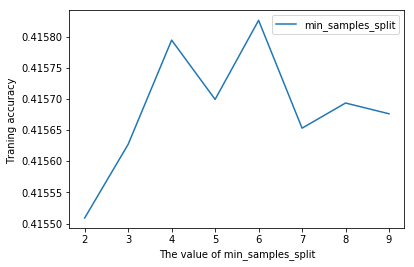

Maximum Accuracy: 0.4158260623275273
Best min_samples_split: 6


In [281]:
# plot for min_samples_split
plt.plot(ms_k, ms_accuracy,label="min_samples_split")
plt.ylabel("Traning accuracy ")
plt.xlabel("The value of min_samples_split")
plt.legend()
plt.show()

print("Maximum Accuracy:",np.max(ms_accuracy))
print("Best min_samples_split:",ms_k[np.argmax(ms_accuracy)])

In [282]:
# cross validation for min_samples_leaf, based on previous best max_depth,best n_estimators, min_samples_split
msl_k = list(range(1,10,1))
msl_accuracy = []
    
for i in range(1, 10, 1):
    RF = RandomForestClassifier(n_estimators=180,max_depth=12,min_samples_split = 6,min_samples_leaf=i)
    msl_accuracy.append(np.mean(cross_val_score(RF, X, y, cv=10)))

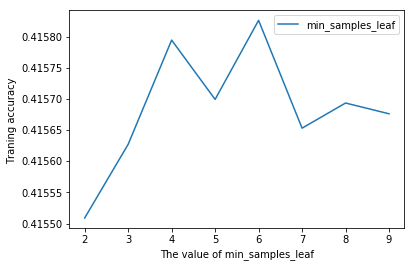

Maximum Accuracy: 0.41246092765465986
Best min_samples_leaf: 7


In [284]:
# plot for min_samples_split
plt.plot(ms_k, ms_accuracy,label="min_samples_leaf")
plt.ylabel("Traning accuracy ")
plt.xlabel("The value of min_samples_leaf")
plt.legend()
plt.show()

print("Maximum Accuracy:",np.max(msl_accuracy))
print("Best min_samples_leaf:",msl_k[np.argmax(msl_accuracy)])

# From Patrick

In [1]:
# load imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
# read data
data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE", "MIN_CALL_DATE_TIME", 
                                                     "EXCEPTION_CREATION_DATE", "SHIFT_START_DATE_TIME"])

C:\Users\tung_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Unnamed: 0,EXCEPTIONID,PCN,EXCEPTION_REASON,EXCEPTION_GROUP,EXCEPTION_HOURS,EXCEPTION_CREATION_DATE,MASKED_REPLACED_EMPLID,LABOR_AGREEMENT,UNION_CD,...,FILL_DATE_TIME,MAX_CALL_TO_FILL_MINUTES,EXCEPTION_CREATION_TO_FILL_MINUTES,EXCEPTION_CREATION_TO_MAXCALL_MINUTES,EXCEPTION_CREATION_TO_SHIFTSTART_MINUTES,EARL_NOTIFICATION_TO_FILL_MINUTES,EARL_NOTIFICATION_TO_SHIFTSTART_MINUTES,FILL_TO_SHIFTSTART_MINUTES,MASKED_SCHEDULER_EMPLID,SCHEDULER_JOBCODE
0,1,7396954,2020.0,MV- Move,Move,7.50,2012-12-05 09:37:08,8708477,FAC,HSA-HSP,...,2013-01-02 14:21:22,0,-40604,-40604,-37283,0,0,-3321,NaN,NaN
1,2,6560094,4716.0,PVC- Vacation Regular,Vacation,7.50,2011-11-20 11:42:41,8703367,PARMED,HSA-HSP,...,NaN,0,0,0,-585888,0,0,0,NaN,NaN
2,3,7070218,8108.0,POT- Time Owing,Leave of Absence,10.75,2012-07-04 08:01:30,8705190,FAC,BCNU-NoUse,...,2012-12-30 18:24:11,0,-258383,-258383,-259139,0,0,756,829627.0,900869.0
3,4,7339325,3012.0,USK- Unpd Sick Lv,Unpaid Sick,7.50,2012-11-09 11:04:40,8702731,FAC,HEU-Fac,...,2012-11-09 11:29:58,0,-25,-25,-74696,0,0,74671,824659.0,900963.0
4,5,7582102,5698.0,PVC- Vacation Regular,Vacation,7.50,2013-02-25 07:32:14,8705354,EXCL,PHC Mgt,...,NaN,0,0,0,80612,0,0,0,NaN,NaN


# Data Wrangling for Classification

The wrangling below is obtained from what I currently see from your wrangling classification file. Please let me know if there is anything else you need help with.

In [17]:
df = data.copy()

df = df[(df["JOB_FAMILY"]=="DC1000") | (df["JOB_FAMILY"]=="DC2A00") | (df["JOB_FAMILY"]=="DC2B00")]
# filter(year(SHIFT_DATE) < 2019,LABOR_AGREEMENT == "NURS")
df = df[(df["SHIFT_DATE"] < "2019-01-01") & (df["LABOR_AGREEMENT"]=="NURS")]
# filter(!grepl('Education|Swap', EXCEPTION_GROUP))
df = df.drop(index=df[(df["EXCEPTION_GROUP"].str.contains("Swap")) | df["EXCEPTION_GROUP"].str.contains("Education")].index)
# filter(!grepl('Relief Not Needed', EARNING_CATEGORY))
df = df.drop(index=df[(df["EARNING_CATEGORY"].str.contains("Relief Not Needed"))].index)
# filter(SITE %in% c("Brock Fahrni", "Holy Family","Mt St Joseph", "St Paul's Hospital", "SVH Langara","Youville Residence"))
df = df[(df["SITE"]=="St Paul's Hospital") | (df["SITE"]=="Mt St Joseph") | 
        (df["SITE"]=="Holy Family") | (df["SITE"]=="SVH Langara") | 
        (df["SITE"]=="Brock Fahrni") | (df["SITE"]=="Youville Residence")]
# mutate(NOTICE = ceiling(as.numeric(SHIFT_START_DATE_TIME - EXCEPTION_CREATION_DATE)/3600)
df["NOTICE"] = np.ceil((df["SHIFT_START_DATE_TIME"] - df["EXCEPTION_CREATION_DATE"]).dt.total_seconds())
# mutate(AWARE = ceiling(as.numeric(MIN_CALL_DATE_TIME - EXCEPTION_CREATION_DATE)))
df["AWARE"] = np.ceil((df["MIN_CALL_DATE_TIME"] - df["EXCEPTION_CREATION_DATE"]).dt.total_seconds())
# mutate(WEEKDAY = weekdays(SHIFT_DATE))
df["WEEKDAY"] = df["SHIFT_DATE"].dt.dayofweek
# mutate(MONTH = month(SHIFT_DATE))
df["MONTH"] = df["SHIFT_DATE"].dt.month
#  select("EXCEPTION_GROUP","WEEKDAY","SITE","MONTH","SUB_PROGRAM","EXCEPTION_HOURS","EXCEPTION_CREATION_DATE","MIN_CALL_DATE_TIME","SHIFT_DATE","NOTICE","AWARE","EARNING_CATEGORY")
df = df.loc[:, ["EXCEPTION_GROUP","WEEKDAY","SITE","MONTH","SUB_PROGRAM","EXCEPTION_HOURS",
                "EXCEPTION_CREATION_DATE","MIN_CALL_DATE_TIME","SHIFT_DATE","NOTICE","AWARE","EARNING_CATEGORY"]]
# filter(NOTICE > 0)
df = df[df["NOTICE"] > 0]
# label "EXCEPTION_GROUP"
exceptiongroup_le = LabelEncoder()
df["EXCEPTION_GROUP"] = exceptiongroup_le.fit_transform(df["EXCEPTION_GROUP"])
# label "SUB_PROGRAM"
subprogram_le = LabelEncoder()
df["SUB_PROGRAM"] = subprogram_le.fit_transform(df["SUB_PROGRAM"])
# label "SITE"
site_le = LabelEncoder()
df["SITE"] = site_le.fit_transform(df["SITE"])

# drop any nas...
df = df.dropna()

In [80]:
# export classification wrangling
df.to_csv("../data/python_classification_wrangling.csv")

# Random Forest Classification attempt

Below is my interpretation of the random forest classification model. It's not as good as Iris's so far, but it might still be helpful.

In [18]:
# combine EARNING_CATEGORIES
combined = []
for i in df["EARNING_CATEGORY"]:
    if ("Straight" in i) or ("Regular" in i) or ("PT" in i):
        combined.append("Straight Time")
    elif ("Agency" in i) or ("Insufficient" in i) or ("On-Call" in i):
        combined.append("Others")
    else:
        combined.append("Overtime and Relief Not Found")
df["EARNING_CATEGORY"] = combined

In [37]:
train = df[(df["SHIFT_DATE"]>"2012-12-31") & (df["SHIFT_DATE"]<"2017-01-01")]
val = df[(df["SHIFT_DATE"]>"2016-12-31") & (df["SHIFT_DATE"]<"2018-01-01")]

In [65]:
Xtrain = train.loc[:, train.columns != "EARNING_CATEGORY"].astype("category")
Xtrain.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]] = Xtrain.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]].astype("float64")
ytrain = train["EARNING_CATEGORY"]

Xval = val.loc[:, val.columns != "EARNING_CATEGORY"].astype("category")
Xval.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]] = Xval.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]].astype("float64")
yval = val["EARNING_CATEGORY"]

In [77]:
rfc = RandomForestClassifier(max_depth=13, n_estimators=200, class_weight="balanced")
rfc.fit(Xtrain, ytrain)
print("Training Accuracy:", rfc.score(Xtrain, ytrain))
print("Validation Accuracy:", rfc.score(Xval, yval))
rfc.feature_importances_

Training Accuracy: 0.8716314510758149
Validation Accuracy: 0.8126146389792612


array([0.12873419, 0.01150631, 0.02180329, 0.00727579, 0.10431342,
       0.22617407, 0.02463836, 0.02563684, 0.01944248, 0.25993179,
       0.17054346])

In [78]:
# print accuracy for each group
for i in df["EARNING_CATEGORY"].unique():
    temp = val[val["EARNING_CATEGORY"]==i]
    X = temp.loc[:, temp.columns != "EARNING_CATEGORY"].astype("category")
    X.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]] = X.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]].astype("float64")
    y = temp["EARNING_CATEGORY"]
    print("Accuracy for",i,":",round(rfc.score(X,y),3))

Accuracy for Straight Time : 0.814
Accuracy for Overtime and Relief Not Found : 0.813
Accuracy for Others : 0.785


In [79]:
# print accuracy for select earning_category
var = "Overtime and Relief Not Found"
temp = val[val["EARNING_CATEGORY"]==var]
X = temp.loc[:, temp.columns != "EARNING_CATEGORY"].astype("category")
X.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]] = X.loc[:, ["EXCEPTION_HOURS", "NOTICE", "AWARE"]].astype("float64")
y = temp["EARNING_CATEGORY"]
predict_overtime = rfc.predict(X)


for i in set(predict_overtime):
    print("Predict",i,"when",var,":",round(list(predict_overtime).count(i)/len(predict_overtime),3))

Predict Overtime and Relief Not Found when Overtime and Relief Not Found : 0.813
Predict Others when Overtime and Relief Not Found : 0.029
Predict Straight Time when Overtime and Relief Not Found : 0.158
